# clearmap2_demo_smartspim-aligncells
In this notebook I will show how to take the raw cells output from ClearMap2 and align them to a brain atlas. To do this you need to have already run elastix to make the inverse transformations between reg and cell channel as well as between the reg channel and the atlas. In this notebook I assume the elastix/ folder that is generated when you run elastix is in the resolution_3.6x/ data folder.

There are 3 steps to this:
1. Raw_cellch -> Resampled_cellch 
2. Resampled_cellch -> Resampled_regch (uses an inverse transformation)
3. Resampled_regch -> atlas (uses an inverse transformation)

## General imports

In [18]:
import os,sys, glob, shutil, pickle
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import SimpleITK as sitk
%matplotlib inline

## Clearmap specific imports

In [19]:
sys.path.append('/jukebox/wang/ahoag/ClearMap2') # change to wherever you have clearmap2 cloned
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ParallelProcessing.BlockProcessing as bp
import ClearMap.ImageProcessing.Experts.Cells as cells
import ClearMap.Settings as settings
import ClearMap.Alignment.Resampling as res
import ClearMap.Alignment.Elastix as elx   
import ClearMap.Alignment.Annotation as ano

In [21]:
# Set up paths. Change if data folders or elastix folder are in different locations
data_dir = os.path.join('/jukebox/LightSheetData/lightserv/cz15/zimmerman_01',
                        'zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x') 
elastix_dir = os.path.join(data_dir,'elastix')
elastix_inverse_dir = os.path.join(data_dir,'elastix_inverse_transform')
ch488_dir = os.path.join(data_dir,'Ex_488_Em_0')
ch642_dir = os.path.join(data_dir,'Ex_642_Em_2')

In [35]:
ch488_downsized_file = os.path.join(ch488_dir,'downsized_for_atlas.tif')
ch488_downsized_vol = tifffile.imread(ch488_downsized_file)
ch642_downsized_file = os.path.join(ch642_dir,'downsized_for_atlas.tif')
ch642_downsized_vol = tifffile.imread(ch642_downsized_file)

## Set up the ClearMap2 workspace

In [22]:
directory = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
             'cz15/zimmerman_01_smartspim/zimmerman_01-001',
             'imaging_request_1/output')

expression_raw      = 'ch647_renamed/corrected/Z<Z,4>.tif'    
expression_auto     = 'ch488_renamed/corrected/Z<Z,4>.tif'

ws = wsp.Workspace('CellMap', directory=directory);
ws.update(raw=expression_raw)
ws.update(autofluorescence=expression_auto)
resources_directory = settings.resources_path
ws.debug=False
ws.info()

Workspace[CellMap]{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zimmerman_01_smartspim/zimmerman_01-001/imaging_request_1/output}
              raw: ch647_renamed/corrected/Z<Z,4>.tif {3589 files, ('Z',): (0,) -> (3588,)}
 autofluorescence: ch488_renamed/corrected/Z<Z,4>.tif {3586 files, ('Z',): (0,) -> (3585,)}
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: resampled.tif
                   resampled_autofluorescence.tif
resampled_to_auto: no file
auto_to_reference: no file
            cells: cells_raw.npy
                   cells_transformed_to_atlas.npy
                   cells_transformed_to_atlas_attempt1.npy
                   cells_transformed_to_atlas_attempt2.npy
                   cells_transformed_to_atlas_attempt3.npy
                   cells_transformed_to_atlas_attempt4.npy
          density: no file



# Align raw cells to atlas

In [23]:
# This is the raw cell volume containing the raw coordinates and some other info not needed for this notebook
ws.source('cells', postfix='raw')

Memmap-Source(4743122,)[[('x', '<i8'), ('y', '<i8'), ('z', '<i8'), ('size', '<i8'), ('source', '<f8'), ('background', '<f8')]]|C|{/jukebox/wang/ahoag/test_clearmap2/output/cz15/zim...rman_01-001/imaging_request_1/output/cells_raw.npy}

In [24]:
# Read into a numpy array
source = ws.source('cells', postfix='raw')
coordinates_raw = np.hstack([source[c][:,None] for c in 'xyz']) 

In [25]:
coordinates_raw

array([[3593, 4549,   10],
       [1974,   70,   60],
       [2600, 3406,   89],
       ...,
       [1629, 2274, 3588],
       [1639, 2286, 3588],
       [2310, 5892, 3588]])

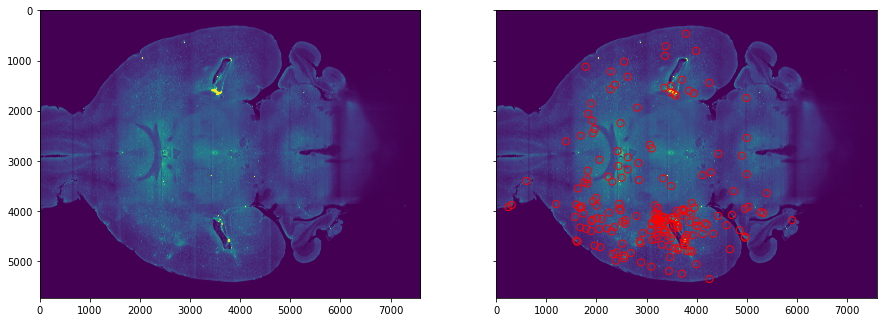

In [27]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
z=2218 # just pick a z plane where we know there will be cells
this_plane_coords = np.array([coord for coord in coordinates_raw if coord[-1] == z])
xs = this_plane_coords[:,0]
ys = this_plane_coords[:,1]
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
stitched_z_plane = ws.source('stitched')[:,:,z] 
ax_tissue.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys[::10],xs[::10],s=50,facecolors='none',edgecolors='r') # [::10] shows every 10th cell. I do this because there are so many cells that showing them all is a mess
plt.show()

(2000.0, 3000.0)

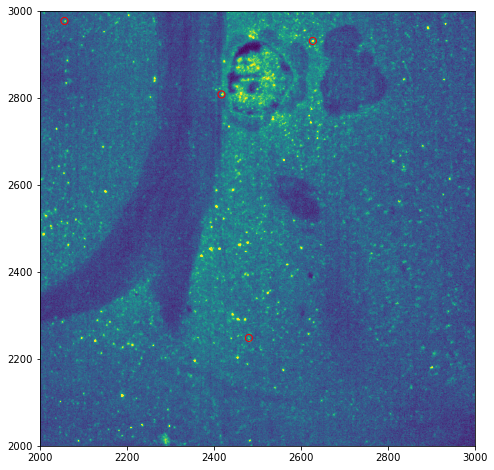

In [30]:
# Zoom in just to make sure cells are actually circled 
fig,ax_both = plt.subplots(figsize=(15,8),nrows=1,ncols=1,)
ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys[::10],xs[::10],s=50,facecolors='none',edgecolors='r') # [::10] shows every 10th cell. I do this because there are so many cells that showing them all is a mess
ax_both.set_xlim(2000,3000)
ax_both.set_ylim(2000,3000)

OK that looks good. Can see that cells are clearly circled. Raw volume is "horizontally" oriented, i.e. z planes are horizontal cuts

The first thing that we did when downsizing the raw data before it was registered was swap the x and z axes. This is done because we want a sagittal orientation, i.e. where z planes are sagittal cuts rather than horizontal cuts. So we need to do that for the cell coordinates before we resample them. 

In [31]:
coordinates_raw_swapped_axes = np.zeros_like(coordinates_raw)
coordinates_raw_swapped_axes[:,0] = coordinates_raw[:,2]
coordinates_raw_swapped_axes[:,1] = coordinates_raw[:,1]
coordinates_raw_swapped_axes[:,2] = coordinates_raw[:,0]

In [32]:
coordinates_raw_swapped_axes

array([[  10, 4549, 3593],
       [  60,   70, 1974],
       [  89, 3406, 2600],
       ...,
       [3588, 2274, 1629],
       [3588, 2286, 1639],
       [3588, 5892, 2310]])

Check the distribution of cells coordinates to have something to compare to when we do the resampling/transforming

Text(0.5, 0.98, 'Distribution of cell centers in raw space (after swapping x and z)')

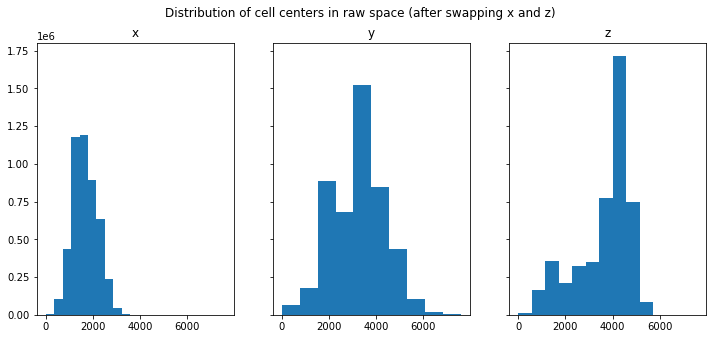

In [45]:
# Check resampled distributions

fig,axes = plt.subplots(figsize=(12,5),nrows=1,ncols=3,sharex=True,sharey=True)

for i, name in enumerate(["x","y","z"]):
    ax = axes[i]
    cellcoords = coordinates_raw_swapped_axes[:,i]
    ax.hist(cellcoords);
    ax.set_title(name)
plt.suptitle("Distribution of cell centers in raw space (after swapping x and z)")

## Step 1. Resampling

So we need to downsize (aka resample) using a source shape where the x and z coordinates have been swapped because we have swapped x and z in the raw cells space 

In [37]:
coordinates_resampled = res.resample_points(
                  coordinates_raw_swapped_axes, sink=None, orientation=None,
                  source_shape=io.shape(ws.filename('stitched'))[::-1], # the [::-1] reverses the order
                  sink_shape=io.shape(ch642_downsized_file));

Text(0.5, 0.98, 'Distribution of cell centers after resampling ')

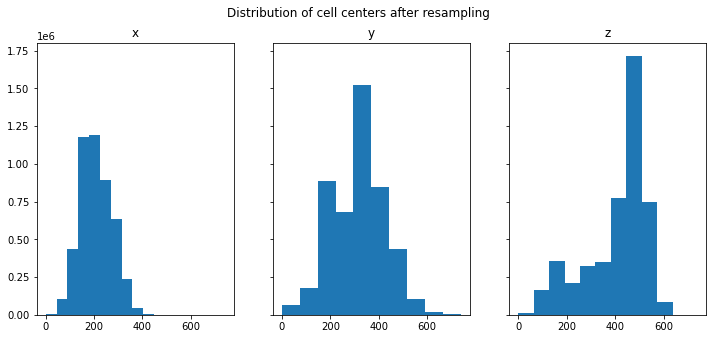

In [46]:
# Check resampled distributions

fig,axes = plt.subplots(figsize=(12,5),nrows=1,ncols=3,sharex=True,sharey=True)

for i, name in enumerate(["x","y","z"]):
    ax = axes[i]
    cellcoords = coordinates_resampled[:,i]
    ax.hist(cellcoords);
    ax.set_title(name)
plt.suptitle("Distribution of cell centers after resampling ")

Distribution of cells looks similar to before resampling which is good! 

Want to visually verify that these cells are still in the correct location as compared to the resampled image

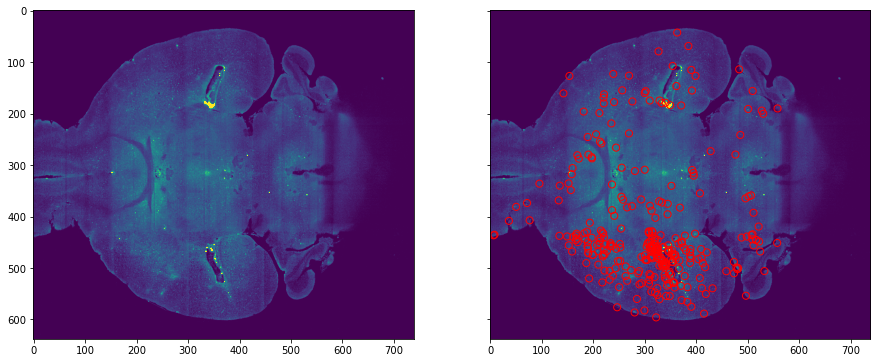

In [49]:
x=278 # the equivalent to z=2000 raw data that we used 
this_plane_coords_resampled = np.array([coord for coord in coordinates_resampled if int(coord[0]) == x])
ys = this_plane_coords_resampled[:,1]
zs = this_plane_coords_resampled[:,2]
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
resampled_z_plane = ch642_downsized_vol[:,:,x]
# resampled_z_plane_fixaxes = np.swapaxes(resampled_z_plane,0,1)
ax_tissue.imshow(resampled_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(resampled_z_plane,vmin=0,vmax=200,cmap='viridis')
ax_both.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')


Cells still look aligned and have same overall general pattern as the raw space plot above.

# Step 2. Transform Resampled cellch -> Resampled regch 
Below the transform_directory parameter needs to be the directory to where the inverse transformation was run, i.e. transforming **FROM regch (488) to cellch (642)**. There needs to be a file TransformParameters.1.txt in this directory. **Do NOT use the regular elastix transformation directory.** 

In [50]:
coordinates_aligned_to_488 = elx.transform_points(
                  coordinates_resampled, sink=None,
                  transform_directory=os.path.join(elastix_inverse_dir,'Ex_488_Em_0_to_Ex_642_Em_2'),
                  binary=True, indices=False);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform/Ex_488_Em_0_to_Ex_642_Em_2/TransformParameters.1.txt


Text(0.5, 0.98, 'Distribution of cell centers in 642 aligned to 488 space')

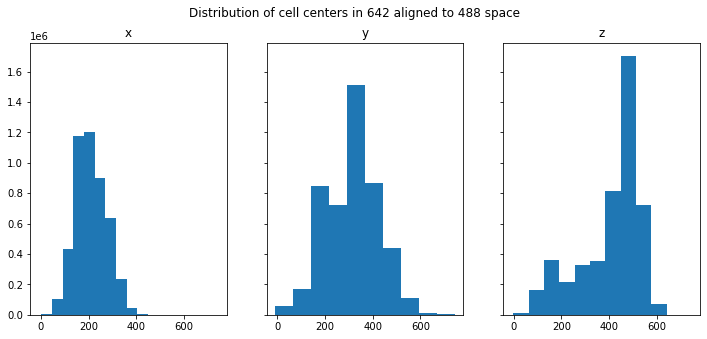

In [51]:
# Check distributions

fig,axes = plt.subplots(figsize=(12,5),nrows=1,ncols=3,sharex=True,sharey=True)

for i, name in enumerate(["x","y","z"]):
    ax = axes[i]
    cellcoords = coordinates_aligned_to_488[:,i]
    ax.hist(cellcoords);
    ax.set_title(name)
plt.suptitle("Distribution of cell centers in 642 aligned to 488 space")

Still looking good but need to do a visual check like we did on the resampled data

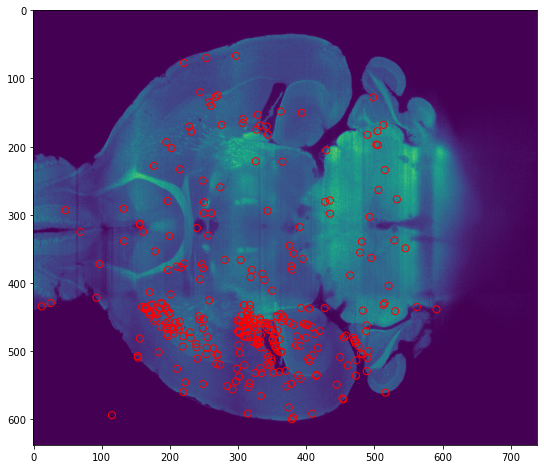

In [53]:
# Verify that raw cells are in the right locations and we understand the x,y,z layout of these clearmap files
x=278
this_plane_coords_aligned_to_488 = np.array([coord for coord in coordinates_aligned_to_488 if int(coord[0]) == x])
ys = this_plane_coords_aligned_to_488[:,1]
zs = this_plane_coords_aligned_to_488[:,2]
fig,ax = plt.subplots(figsize=(15,8),nrows=1,ncols=1,sharex=True,sharey=True)
resampled_z_plane = ch488_downsized_vol[:,:,x]
ax.imshow(resampled_z_plane,vmin=0,vmax=1000,cmap='viridis')
ax.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')


Still looks good. Note that this is the registration channel so we don't expect to see cells in the tissue. What we are checking here is that the circles (which represent the coordinates of the detected cells) are still aligned to the tissue like they were to the resampled cell channel above. 

## Step 3. Transform Regch -> Princeton Mouse Atlas
This is the final step and the result will be the cell coordinates aligned to the Princeton Mouse Atlas. The transform_directory here is the inverse transform directory, i.e. the location where the results from transforming resampled 488 -> atlas are. In this example these files live in:

In [55]:
elastix_inverse_dir

'/jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform'

In [54]:
coordinates_aligned_to_atlas = elx.transform_points(
                  coordinates_aligned_to_488, sink=None,
                  transform_directory=elastix_inverse_dir,
                  binary=True, indices=False);

/jukebox/wang/ahoag/ClearMap2/ClearMap/External/elastix/build/bin/transformix -def /tmp/elastix_input.bin -out /tmp/elastix_output -tp /jukebox/LightSheetData/lightserv/cz15/zimmerman_01/zimmerman_01-001/imaging_request_1/rawdata/resolution_3.6x/elastix_inverse_transform/TransformParameters.1.txt


Check the distributions once again

Text(0.5, 0.98, 'Distribution of cell centers in 642 aligned to 488 space')

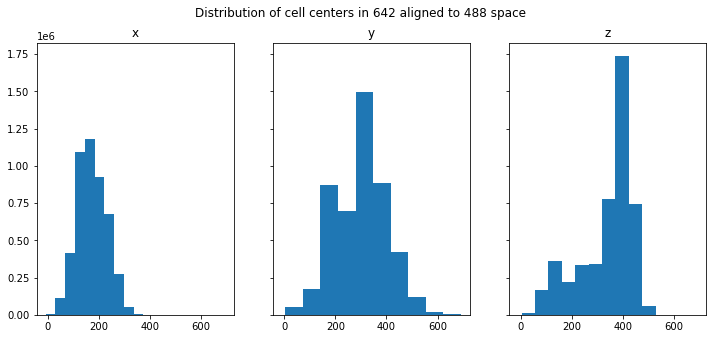

In [56]:
# Check distributions

fig,axes = plt.subplots(figsize=(12,5),nrows=1,ncols=3,sharex=True,sharey=True)

for i, name in enumerate(["x","y","z"]):
    ax = axes[i]
    cellcoords = coordinates_aligned_to_atlas[:,i]
    ax.hist(cellcoords);
    ax.set_title(name)
plt.suptitle("Distribution of cell centers in 642 aligned to 488 space")

That looks consistent with the previous plots

In [58]:
# Load the princeton mouse atlas tissue volume
pma_file = '/jukebox/LightSheetTransfer/atlas/sagittal_atlas_20um_iso.tif'
pma_vol = tifffile.imread(pma_file)

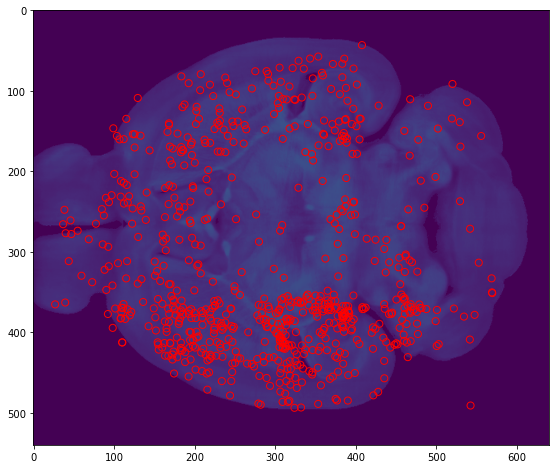

In [61]:
# Verify that cells are still in the right locations 
fig,ax = plt.subplots(figsize=(15,8),nrows=1,ncols=1,)
resampled_z_plane = pma_vol[:,:,x]
x=150
this_plane_coords_aligned_to_atlas = np.array([coord for coord in coordinates_aligned_to_atlas if int(coord[0]) == x])
ys = this_plane_coords_aligned_to_atlas[:,1]
zs = this_plane_coords_aligned_to_atlas[:,2]
ax.imshow(resampled_z_plane,vmin=0,vmax=1000,cmap='viridis')
ax.scatter(ys[::50],zs[::50],s=50,facecolors='none',edgecolors='r')

Still looks good!

# Save the registered cells

In [62]:
# Save the registered cells
header = ['x','y','z'];
dtypes = [int, int, int];

dt = {'names' : header, 'formats' : dtypes};
cells_out = np.zeros(len(coordinates_aligned_to_atlas), dtype=dt);
for i,h in enumerate(header):
    cells_out[h] = coordinates_aligned_to_atlas[:,i];

In [63]:
cells_out

array([( -9, 413, 328), (  5,  20, 185), (  0, 310, 241), ...,
       (372, 214, 148), (372, 216, 149), (374, 533, 230)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('z', '<i8')])

In [ ]:
# save the array as an npy file in the same place as the cells_raw.npy file you used as input lives
savename = ws.filename('cells',postfix='transformed_to_atlas')
io.write(savename,cells_out)